In [1]:
import numpy as np
import pandas as pd
#from datetime import datetime
import datetime
import time
import numba
import os,sys

def LoadData(InputDir):
    """"""
    ## load raw data
    data = {
        'tra': pd.read_csv('%s/air_visit_data.csv' % InputDir, parse_dates= ['visit_date']),
        'as': pd.read_csv('%s/air_store_info.csv' % InputDir),
        'hs': pd.read_csv('%s/hpg_store_info.csv' % InputDir),
        'ar': pd.read_csv('%s/air_reserve.csv' % InputDir, parse_dates= ['visit_datetime', 'reserve_datetime']),
        'hr': pd.read_csv('%s/hpg_reserve.csv' % InputDir, parse_dates= ['visit_datetime', 'reserve_datetime']),
        'id': pd.read_csv('%s/store_id_relation.csv' % InputDir),
        'tes': pd.read_csv('%s/sample_submission.csv' % InputDir),
        'hol': pd.read_csv('%s/date_info.csv' % InputDir, parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})
    }
    return data

@numba.jit
def ApplyDayoff(VisitCols, ReserveCols):
    """"""
    n = len(VisitCols)
    result = np.zeros((n, 1), dtype= 'int8')
    for i in range(n):
        result[i] = (VisitCols[i]- ReserveCols[i]).days
    return result

In [2]:
mod2id = {'ar': 'air', 'hr': 'hpg'}
### load data set
InputDir = '../../data/raw'
DataSet = LoadData(InputDir)

### date related features
print('\n============')
for mod in ['tra', 'tes']:
    start0 = time.time()
    if (mod == 'tes'):
        DataSet[mod]['visit_date'] = DataSet[mod]['id'].map(lambda x: str(x).split('_')[2])
        DataSet[mod]['air_store_id'] = DataSet[mod]['id'].map(lambda x: '_'.join(x.split('_')[:2]))
        DataSet[mod]['visit_date'] = pd.to_datetime(DataSet[mod]['visit_date'])
    DataSet[mod]['dow'] = DataSet[mod]['visit_date'].dt.dayofweek
    DataSet[mod]['year'] = DataSet[mod]['visit_date'].dt.year
    DataSet[mod]['month'] = DataSet[mod]['visit_date'].dt.month
    DataSet[mod]['visit_date'] = DataSet[mod]['visit_date'].dt.date
    end0 = time.time()
    print('%s data: unique stores %s, total %s, time elased %.2fs.' %
            (mod, len(DataSet[mod]['air_store_id'].unique()), len(DataSet[mod]['air_store_id']), (end0 - start0)))
print('')
# for reservation data
for mod in ['hr', 'ar']:
    start1 = time.time()
    DataSet[mod]['visit_date'] = DataSet[mod]['visit_datetime'].dt.date
    DataSet[mod].drop(['visit_datetime'], axis= 1, inplace= True)
    DataSet[mod]['reserve_date'] = DataSet[mod]['reserve_datetime'].dt.date
    DataSet[mod].drop(['reserve_datetime'], axis= 1, inplace= True)
    end1 = time.time()
    print('time-consuming part %.2f.' % (end1 - start1))
end0 = time.time()
print('=============')
print('process date done, time consumed %.2f.\n' % (end0 - start0))


tra data: unique stores 829, total 252108, time elased 0.71s.
tes data: unique stores 821, total 32019, time elased 0.13s.

time-consuming part 10.43.
time-consuming part 0.46.
process date done, time consumed 11.02.



In [19]:
DataSet['tra']['air_store_id'].unique()[:50]

array(['air_ba937bf13d40fb24', 'air_25e9888d30b386df',
       'air_8e4360a64dbd4c50', 'air_35512c42db0868da',
       'air_a271c9ba19e81d17', 'air_fd6aac1043520e83',
       'air_64d4491ad8cdb1c6', 'air_cf22e368c1a71d53',
       'air_f3f9824b7d70c3cf', 'air_820d1919cbecaa0a',
       'air_9ae7081cb77dc51e', 'air_d69b08a175bc0387',
       'air_ee3a01f0c71a769f', 'air_9438d67241c81314',
       'air_3e93f3c81008696d', 'air_cb935ff8610ba3d3',
       'air_9bf595ef095572fb', 'air_876d7a23c47811cb',
       'air_6902e4ec305b3d08', 'air_cd5f54969be9ed08',
       'air_d0e8a085d8dc83aa', 'air_5c65468938c07fa5',
       'air_e8ed9335d0c38333', 'air_9fc607777ad76b26',
       'air_b80fed1a07c817d2', 'air_45326ebb8dc72cfb',
       'air_6ca1d941c8199a67', 'air_37189c92b6c761ec',
       'air_7514d90009613cd6', 'air_8b4a46dc521bfcfe',
       'air_326ca454ef3558bc', 'air_7ef9a5ea5c8fe39f',
       'air_831658500aa7c846', 'air_eec5e572b9eb9c23',
       'air_90f0efbb702d77b7', 'air_256be208a979e023',
       'ai

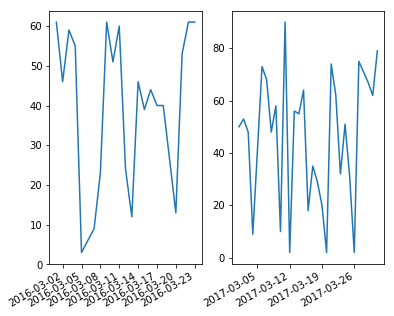

In [20]:
from pylab import *
import matplotlib as mpl
import datetime

sid = 'air_082908692355165e'

data = DataSet['tra']
partial1 = data[(data['air_store_id'] == sid) & (data['visit_date'] >= datetime.date(2016, 3, 1)) & (data['visit_date'] < datetime.date(2016, 4, 1))]
partial2 = data[(data['air_store_id'] == sid) & (data['visit_date'] >= datetime.date(2017, 3, 1)) & (data['visit_date'] < datetime.date(2017, 4, 1))]

fig = figure()
subplot(121)
ax = gca()
ax.plot_date(partial1['visit_date'], partial1['visitors'], linestyle='-', marker='')
# specify formater
date_format = mpl.dates.DateFormatter('%Y-%m-%d')
# apply formater
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate(ha='right',bottom=0.0)

subplot(122)
ax = gca()
ax.plot_date(partial2['visit_date'], partial2['visitors'], linestyle='-', marker='')
# specify formater
date_format = mpl.dates.DateFormatter('%Y-%m-%d')
# apply formater
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate(ha='right',bottom=0.0)

fig.autofmt_xdate(ha='right',bottom=0.0)

show()

In [26]:
data = DataSet['hol']
partial = data[(data['visit_date'] >= datetime.date(2017, 5, 1)) & (data['visit_date'] < datetime.date(2017, 5, 30))]
print(partial)

    visit_date day_of_week  holiday_flg
486 2017-05-01      Monday            0
487 2017-05-02     Tuesday            0
488 2017-05-03   Wednesday            1
489 2017-05-04    Thursday            1
490 2017-05-05      Friday            1
491 2017-05-06    Saturday            0
492 2017-05-07      Sunday            0
493 2017-05-08      Monday            0
494 2017-05-09     Tuesday            0
495 2017-05-10   Wednesday            0
496 2017-05-11    Thursday            0
497 2017-05-12      Friday            0
498 2017-05-13    Saturday            0
499 2017-05-14      Sunday            0
500 2017-05-15      Monday            0
501 2017-05-16     Tuesday            0
502 2017-05-17   Wednesday            0
503 2017-05-18    Thursday            0
504 2017-05-19      Friday            0
505 2017-05-20    Saturday            0
506 2017-05-21      Sunday            0
507 2017-05-22      Monday            0
508 2017-05-23     Tuesday            0
509 2017-05-24   Wednesday            0
